# Deep Reinforcement Learning for Portfolio Optimization - MLP Architecture


This experiement demonstrates the application of deep reinforcement learning (DRL) techniques for portfolio optimization.

- Policy network architecture: **MLP backbone**
- Compares `A2C`, `PPO`, `SAC`, `DDPG` all with simple MLPs

## Dependencies


In [31]:
# ! pip install pandas numpy matplotlib \
#                stable-baselines3 \
#                PyPortfolioOpt \
#                pandas_market_calendars quantstats gymnasium \
#                git+https://github.com/AI4Finance-Foundation/FinRL.git -q

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

import torch

from stable_baselines3 import A2C, PPO, SAC, DDPG
from stable_baselines3.common.noise import NormalActionNoise

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent, DRLEnsembleAgent
from finrl.plot import backtest_stats, get_daily_return, get_baseline, backtest_plot

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [33]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

%matplotlib inline

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
experiment_name = "mlp_4_models"
results_dir = f"results/models/{experiment_name}"
os.makedirs(results_dir, exist_ok=True)

## Data loading and pre-processing


Define training and trading/test periods


In [36]:
start_date = "2015-01-01"
end_date = (datetime.now() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")  # Yesterday

trade_period = 2  # 2 years for testing
train_period = 10  # 10 years for training

train_end_date = (
    datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=trade_period * 365)
).strftime("%Y-%m-%d")
train_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") - timedelta(days=train_period * 365)
).strftime("%Y-%m-%d")
test_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") + timedelta(days=1)
).strftime("%Y-%m-%d")

train_dates = (train_start_date, train_end_date)
test_dates = (test_start_date, end_date)

print(f"Training period: {train_dates}")
print(f"Testing period: {test_dates}")

Training period: ('2013-05-02', '2023-04-30')
Testing period: ('2023-05-01', '2025-04-29')


- Fetch historical stock data for a given list of tickers within a specified date range.
- We use the DOW_30_TICKER stocks
- The data includes `date`, `close`, `high`, `low`, `open`, `volume`, and `tic` (ticker symbol).


In [37]:
def download_data(tickers, start_date, end_date):
    print(f"Downloading {start_date} → {end_date}")
    return YahooDownloader(
        start_date=start_date, end_date=end_date, ticker_list=tickers
    ).fetch_data()


df = download_data(config_tickers.DOW_30_TICKER, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (76791, 8)


==========

We apply feature engineering to the dataset of stock data:

- Add technical indicators (e.g., moving averages, RSI).
- Calculate turbulence indicators, which measure market volatility.

This Enhance the dataset with features that are critical for modeling market dynamics and making informed trading decisions.


In [38]:
def preprocess_data(df):
    fe = FeatureEngineer(use_technical_indicator=True, use_turbulence=True)
    return fe.preprocess_data(df)


df_feat = preprocess_data(df)

# TODO: Normalise the data??

Successfully added technical indicators
Successfully added turbulence index


## Covariance & Returns for State


- Calculate the rolling covariance matrices and daily returns for the given dataset of stock prices.
- This prepares the state representation (the state of the portfolio) for the RL models in the RL environments for portfolio optimization.
- The **rolling covariance matrices** (`cov_list`) capture the relationships between asset returns, while the daily returns (`return_list`) provide information about recent price movements.
- These metrics are critical for modeling the dynamics of the financial market and making informed trading decisions.


In [39]:
def compute_covariance_and_returns(df_feat, lookback=252):
    df_sorted = df_feat.sort_values(["date", "tic"], ignore_index=True)
    df_sorted.index = df_sorted.date.factorize()[0]
    cov_list, return_list = [], []

    dates = df_sorted.date.unique()
    for i in range(lookback, len(dates)):
        win = df_sorted.loc[i - lookback : i]
        pm = win.pivot_table(index="date", columns="tic", values="close")
        rm = pm.pct_change().dropna()
        cov_list.append(rm.cov().values)
        return_list.append(rm)
    df_cov = pd.DataFrame(
        {"date": dates[lookback:], "cov_list": cov_list, "return_list": return_list}
    )

    return pd.merge(df_feat, df_cov, on="date", how="left").dropna(subset=["cov_list"])


df_all = compute_covariance_and_returns(df_feat)

## Train/Trade split


In [40]:
def split_data(df_all, train_dates, test_dates):
    train = data_split(df_all, *train_dates)
    test = data_split(df_all, *test_dates)
    return train, test


train, test = split_data(df_all, train_dates, test_dates)

## Environment setup


- Create instances of the StockPortfolioEnv class for both training and testing datasets.
- It also wrap the training environment for use with Stable-Baselines3 (SB3).


In [41]:
def configure_environment(train, test, fe):
    stock_dim = len(train.tic.unique())
    env_kwargs = dict(
        stock_dim=stock_dim,  # Number of unique stocks
        hmax=100,  # Maximum number of shares that can be traded
        initial_amount=1e6,  # Initial portfolio value (e.g., $1,000,000)
        transaction_cost_pct=0.001,  # Transaction cost as a percentage (e.g., 0.1%)
        reward_scaling=1e-4,  # Scaling factor for rewards
        state_space=stock_dim,  # State space dimension (equal to stock_dim)
        action_space=stock_dim,  # Action space dimension (equal to stock_dim)
        tech_indicator_list=fe.tech_indicator_list,  # List of technical indicators
    )

    # create the two StockPortfolioEnv objects
    raw_train_env = StockPortfolioEnv(df=train, **env_kwargs)
    raw_test_env = StockPortfolioEnv(df=test, **env_kwargs)

    # Wrap the *training* env for SB3
    env_train_sb3, _ = raw_train_env.get_sb_env()

    return env_train_sb3, raw_train_env, raw_test_env, env_kwargs


env_train_sb3, raw_train_env, raw_test_env, env_kwargs = configure_environment(
    train, test, FeatureEngineer()
)

## Training


- We define the configuration for various RL models to be trained in the portfolio optimization environment.
- The training environment (`env_train_sb3`) is wrapped for use with Stable-Baselines3 (SB3).
- The SB3 environment provides the `state` and `action space` dimensions needed for configuring the models.


In [42]:
def prepare_models(env_train_sb3):
    n_actions = env_train_sb3.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
    )
    model_configs = [
        (A2C, "A2C", {}),
        (PPO, "PPO", {}),
        (SAC, "SAC", {}),
        (DDPG, "DDPG", {"action_noise": action_noise}),
    ]
    return model_configs


model_configs = prepare_models(env_train_sb3)

Train multiple reinforcement learning (RL) models using the specified training environment and configuration.


In [ ]:
def train_models(env_train_sb3, model_configs, save_dir, timesteps=200_000):
    models, training_times = {}, {}

    for cls, name, kwargs in model_configs:
        print(f"Training {name}...")
        start_time = time.time()
        model = cls("MlpPolicy", env_train_sb3, verbose=0, **kwargs)
        model.learn(total_timesteps=timesteps)
        end_time = time.time()
        training_times[name] = (end_time - start_time) / 60
        models[name] = model
        model.save(f"{save_dir}/{name}_mlp_model")
        print(f"{name} training completed in {training_times[name]:.2f} minutes.")

    return models, training_times

In [44]:
models, training_times = train_models(env_train_sb3, model_configs, results_dir)

Training A2C...
begin_total_asset:1000000.0
end_total_asset:2526912.905262963
Sharpe:  0.778782501396521
begin_total_asset:1000000.0
end_total_asset:2797463.8296780894
Sharpe:  0.8635571122595862
begin_total_asset:1000000.0
end_total_asset:2596834.294411252
Sharpe:  0.8035582654208983
begin_total_asset:1000000.0
end_total_asset:2566627.349967565
Sharpe:  0.7848140418212227
begin_total_asset:1000000.0
end_total_asset:2704431.6076063863
Sharpe:  0.8230866360368854
begin_total_asset:1000000.0
end_total_asset:2524717.5966410134
Sharpe:  0.7817466579310314
begin_total_asset:1000000.0
end_total_asset:2574993.6305965395
Sharpe:  0.8045147693631949
begin_total_asset:1000000.0
end_total_asset:2577222.9626137526
Sharpe:  0.8000130774625078
begin_total_asset:1000000.0
end_total_asset:2614359.480692271
Sharpe:  0.807337626518051
begin_total_asset:1000000.0
end_total_asset:2610791.7210643105
Sharpe:  0.8020462038303456
begin_total_asset:1000000.0
end_total_asset:2505913.5859471406
Sharpe:  0.769250

/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.71GB > 2.91GB
  warnings.warn(


begin_total_asset:1000000.0
end_total_asset:2578105.292556136
Sharpe:  0.7992174420776651
begin_total_asset:1000000.0
end_total_asset:2528222.237398252
Sharpe:  0.7853449969556112
begin_total_asset:1000000.0
end_total_asset:2527942.654980158
Sharpe:  0.7852556682225244
begin_total_asset:1000000.0
end_total_asset:2526939.5335605093
Sharpe:  0.7849684726043346
begin_total_asset:1000000.0
end_total_asset:2528059.308095642
Sharpe:  0.7853023024878715
begin_total_asset:1000000.0
end_total_asset:2527304.2191952923
Sharpe:  0.7850724401320917
begin_total_asset:1000000.0
end_total_asset:2528564.2347281845
Sharpe:  0.7853807200101782
begin_total_asset:1000000.0
end_total_asset:2531157.016646611
Sharpe:  0.7861408444831863
begin_total_asset:1000000.0
end_total_asset:2528963.1821943386
Sharpe:  0.7854872780391939
begin_total_asset:1000000.0
end_total_asset:2527438.7154840557
Sharpe:  0.7850727977772913
begin_total_asset:1000000.0
end_total_asset:2532749.269380314
Sharpe:  0.786593936360037
begin_

/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.71GB > 3.42GB
  warnings.warn(


begin_total_asset:1000000.0
end_total_asset:2691732.1119276052
Sharpe:  0.8161608238264787
begin_total_asset:1000000.0
end_total_asset:2709221.5509826173
Sharpe:  0.8203101419171901
begin_total_asset:1000000.0
end_total_asset:2738321.3843448367
Sharpe:  0.827792779117325
begin_total_asset:1000000.0
end_total_asset:2720521.268669979
Sharpe:  0.8236280535159758
begin_total_asset:1000000.0
end_total_asset:2725439.495027929
Sharpe:  0.824750179044222
begin_total_asset:1000000.0
end_total_asset:2704498.033638118
Sharpe:  0.8188051941782684
begin_total_asset:1000000.0
end_total_asset:2727271.988849313
Sharpe:  0.8253032102893286
begin_total_asset:1000000.0
end_total_asset:2718218.946811459
Sharpe:  0.8228016417486517
begin_total_asset:1000000.0
end_total_asset:2715553.6462362465
Sharpe:  0.8222011991493305
begin_total_asset:1000000.0
end_total_asset:2735170.3812421653
Sharpe:  0.8273808144383109
begin_total_asset:1000000.0
end_total_asset:2725320.289544373
Sharpe:  0.8247509391511373
begin_t

In [45]:
training_times_df = pd.DataFrame(
    list(training_times.items()), columns=["model", "training_duration (min)"]
)

training_times_df.to_csv(f"{results_dir}/training_times.csv", index=False)

print("Training summary:")
display(training_times_df)

Training summary:


,model,training_duration (min)
0,A2C,3.621345
1,PPO,3.074479
2,SAC,46.643784
3,DDPG,38.400101


## Model loading


Load the trained models from memory for analysis without the need for time consuming retraining


In [69]:
def load_models(model_configs, results_dir):
    models = {}
    for _, name, _ in model_configs:
        model_path = f"{results_dir}/{name}_mlp_model.zip"
        if os.path.exists(model_path):
            print(f"Loading saved model for {name}...")
            models[name] = globals()[name].load(model_path)
        else:
            print(f"No saved model found for {name}.")
    return models


# models = load_models(model_configs, results_dir)

Loading saved model for A2C...
Loading saved model for PPO...
Loading saved model for SAC...
Loading saved model for DDPG...


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.71GB > 3.09GB
  warnings.warn(
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.71GB > 3.10GB
  warnings.warn(


## Backtesting


- Evaluates the performance of the RL models/algorithms in a trading environment.
- We do this by calculating the **cumulative portfolio value** and **performance metrics** for each RL model.


In [57]:
def backtest_rl_strategies(models, raw_env, env_kwargs):
    results = {}
    for name, model in models.items():
        print(f"Backtesting {name}…")
        # Simulate trading using the model in the raw_env environment
        df_ret, _ = DRLAgent.DRL_prediction(
            model=model, environment=raw_env, deterministic=True
        )
        df_ret["account_value"] = (df_ret.daily_return + 1).cumprod() * env_kwargs[
            "initial_amount"
        ]
        stats = backtest_stats(df_ret, value_col_name="account_value")
        results[name] = {"df": df_ret, "stats": stats}
    return results


results = backtest_rl_strategies(models, raw_test_env, env_kwargs)

Backtesting A2C…
begin_total_asset:1000000.0
end_total_asset:1230624.4040450412
Sharpe:  0.8642212892722487
hit end!
Annual return          0.110256
Cumulative returns     0.230624
Annual volatility      0.131050
Sharpe ratio           0.865088
Calmar ratio           0.854477
Stability              0.888910
Max drawdown          -0.129034
Omega ratio            1.169014
Sortino ratio          1.288912
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.009683
Daily value at risk   -0.016061
dtype: float64
Backtesting PPO…
begin_total_asset:1000000.0
end_total_asset:1216958.0485568454
Sharpe:  0.7973812796923337
hit end!
Annual return          0.104025
Cumulative returns     0.216958
Annual volatility      0.135741
Sharpe ratio           0.798180
Calmar ratio           0.708035
Stability              0.869242
Max drawdown          -0.146921
Omega ratio            1.157937
Sortino ratio          1.175795
Skew                        NaN
Kurtosis       

### Plotting


[*********************100%***********************]  1 of 1 completed

Plotting A2C…
Shape of DataFrame:  (500, 8)


Start date,2023-05-01
End date,2025-04-28
Total months,23
,Backtest
Annual return,11.026%
Cumulative returns,23.062%
Annual volatility,13.105%
Sharpe ratio,0.87
Calmar ratio,0.85
Stability,0.89
Max drawdown,-12.903%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.90,2025-02-19,2025-04-08,NaT,NaN
1,8.58,2023-08-01,2023-10-27,2023-11-30,88
2,5.94,2024-03-28,2024-04-17,2024-07-17,80
3,5.14,2024-07-17,2024-08-07,2024-08-23,28
4,4.51,2024-11-29,2025-01-02,2025-01-23,40


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.04%,-5.67%,7.15%


[*********************100%***********************]  1 of 1 completed

Plotting PPO…
Shape of DataFrame:  (500, 8)


Start date,2023-05-01
End date,2025-04-28
Total months,23
,Backtest
Annual return,10.402%
Cumulative returns,21.696%
Annual volatility,13.574%
Sharpe ratio,0.80
Calmar ratio,0.71
Stability,0.87
Max drawdown,-14.692%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.69,2025-02-19,2025-04-08,NaT,NaN
1,8.68,2023-08-01,2023-10-27,2023-11-30,88
2,6.38,2024-07-17,2024-08-07,2024-08-30,33
3,5.77,2024-03-28,2024-04-17,2024-07-17,80
4,4.61,2024-11-29,2025-01-10,2025-01-23,40


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.04%,-5.73%,7.77%


[*********************100%***********************]  1 of 1 completed

Plotting SAC…
Shape of DataFrame:  (500, 8)


Start date,2023-05-01
End date,2025-04-28
Total months,23
,Backtest
Annual return,12.753%
Cumulative returns,26.89%
Annual volatility,13.335%
Sharpe ratio,0.97
Calmar ratio,0.95
Stability,0.91
Max drawdown,-13.447%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.45,2025-02-28,2025-04-08,NaT,NaN
1,9.30,2023-07-26,2023-10-27,2023-11-30,92
2,5.95,2024-03-28,2024-04-17,2024-05-17,37
3,5.20,2024-07-17,2024-08-07,2024-08-21,26
4,5.06,2024-11-29,2025-01-10,2025-01-27,42


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.05%,-5.81%,7.12%


[*********************100%***********************]  1 of 1 completed

Plotting DDPG…
Shape of DataFrame:  (500, 8)


Start date,2023-05-01
End date,2025-04-28
Total months,23
,Backtest
Annual return,12.66%
Cumulative returns,26.683%
Annual volatility,13.421%
Sharpe ratio,0.96
Calmar ratio,0.85
Stability,0.90
Max drawdown,-14.845%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.85,2025-02-19,2025-04-08,NaT,NaN
1,8.41,2023-08-01,2023-10-27,2023-11-24,84
2,5.82,2024-07-17,2024-08-05,2024-08-23,28
3,5.31,2024-11-29,2025-01-10,2025-01-27,42
4,5.24,2024-03-28,2024-04-15,2024-07-16,79


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.05%,-5.64%,7.75%


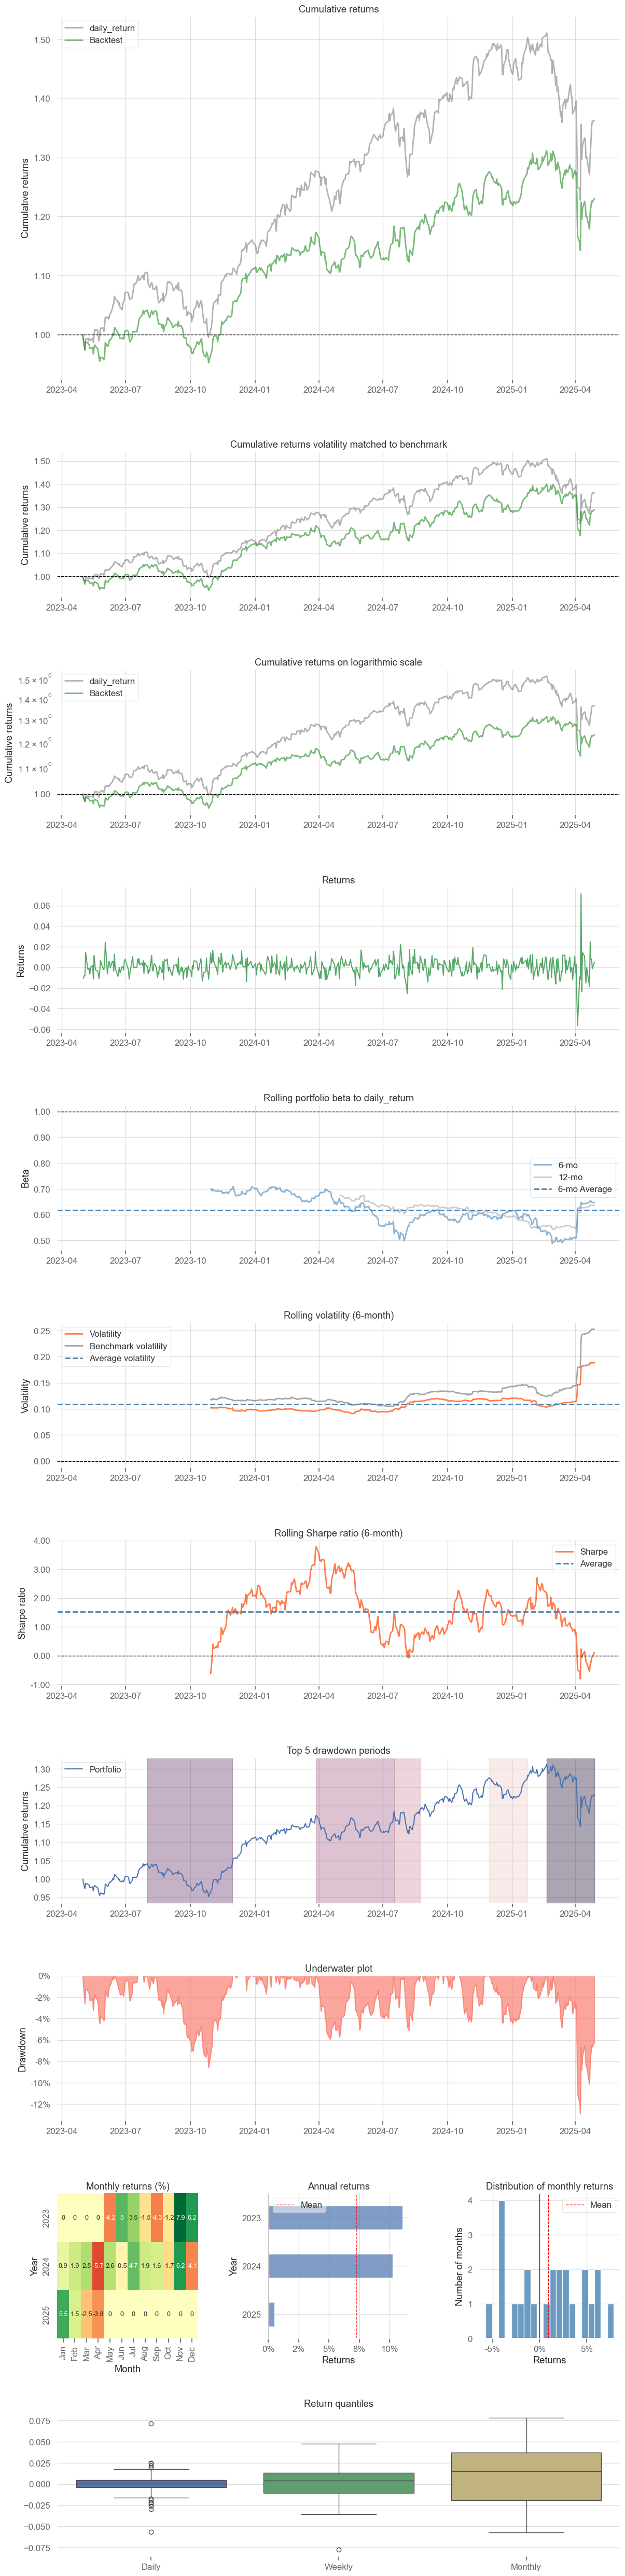

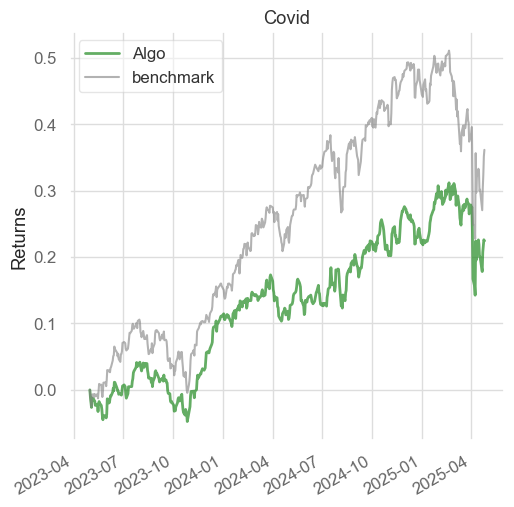

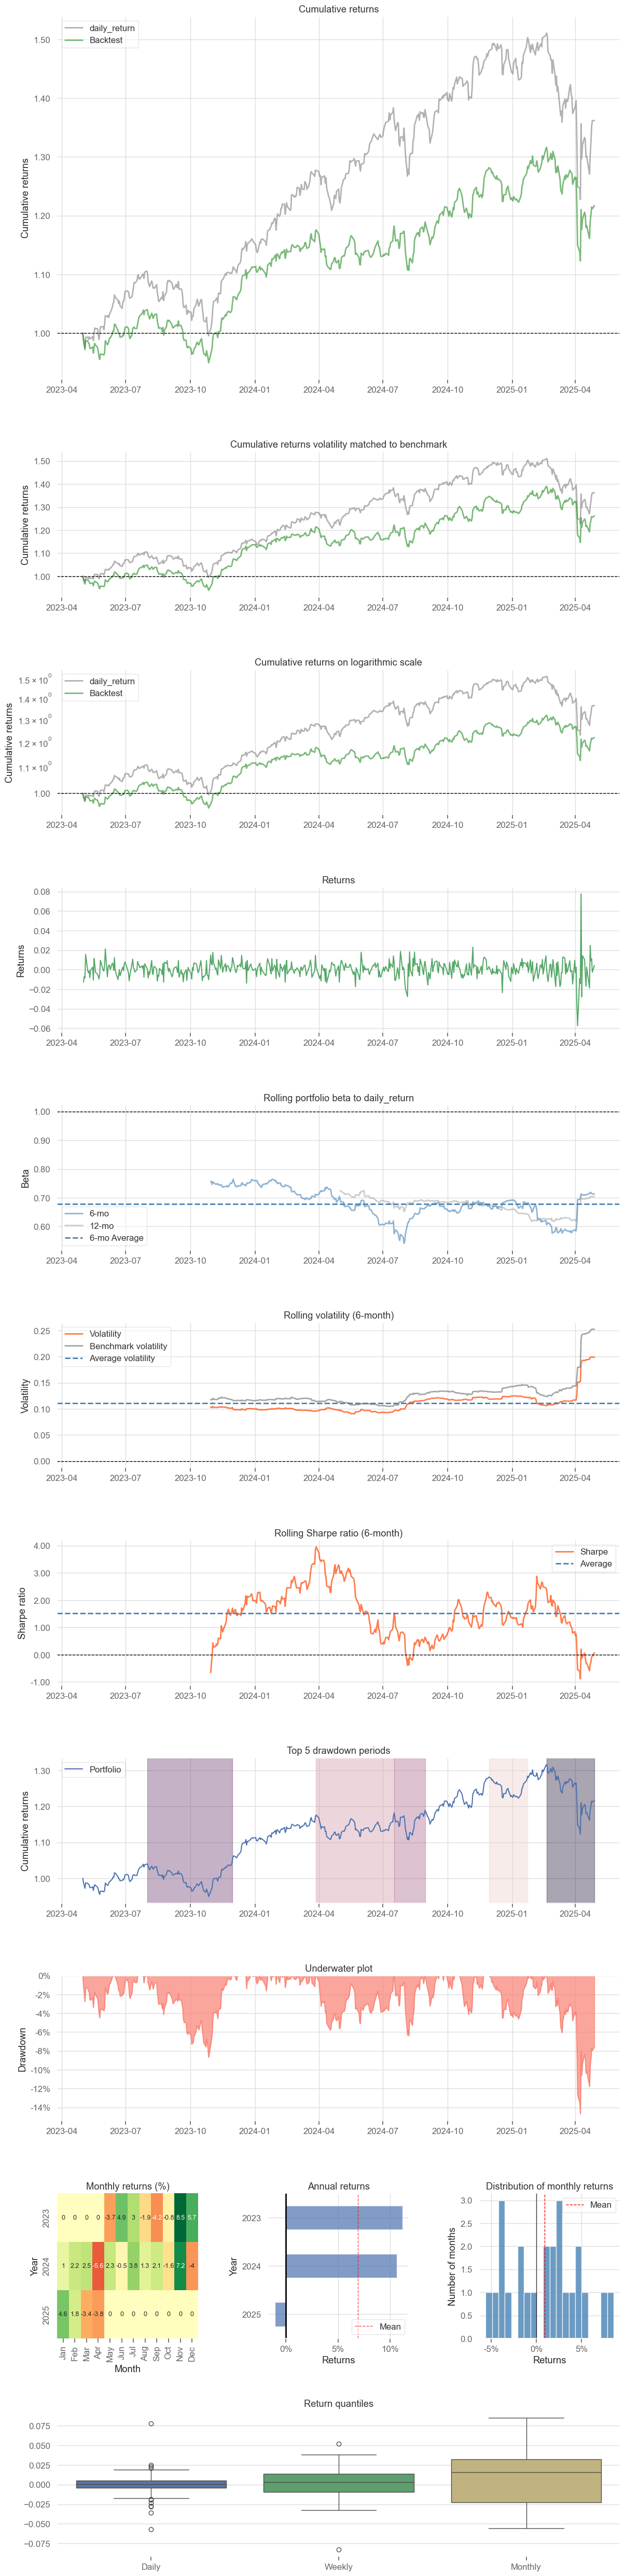

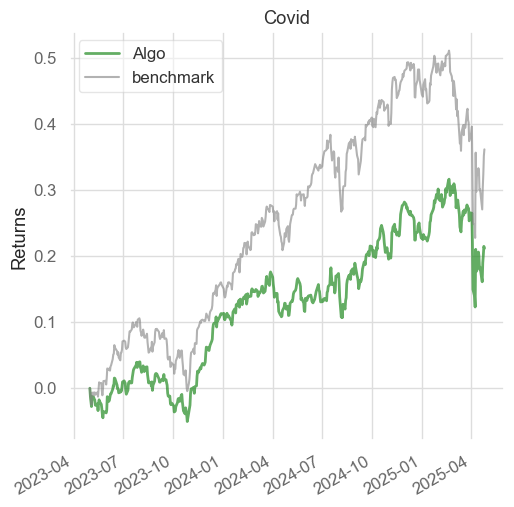

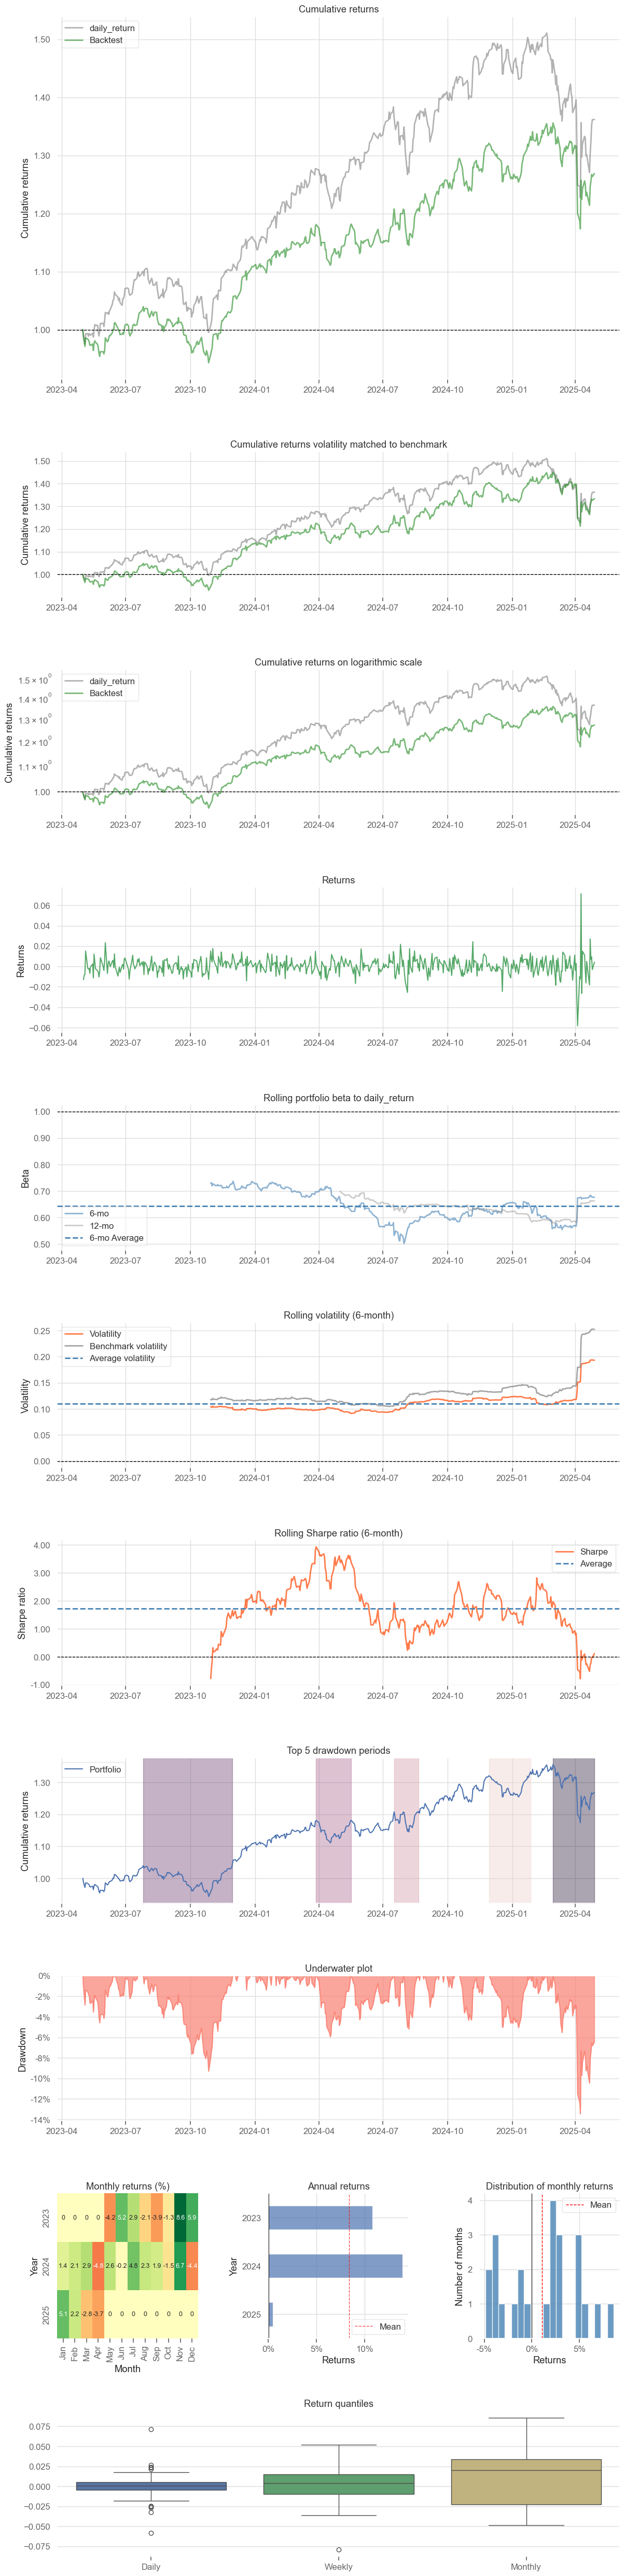

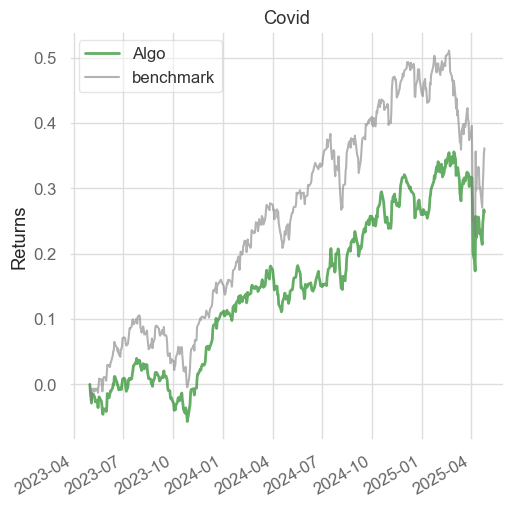

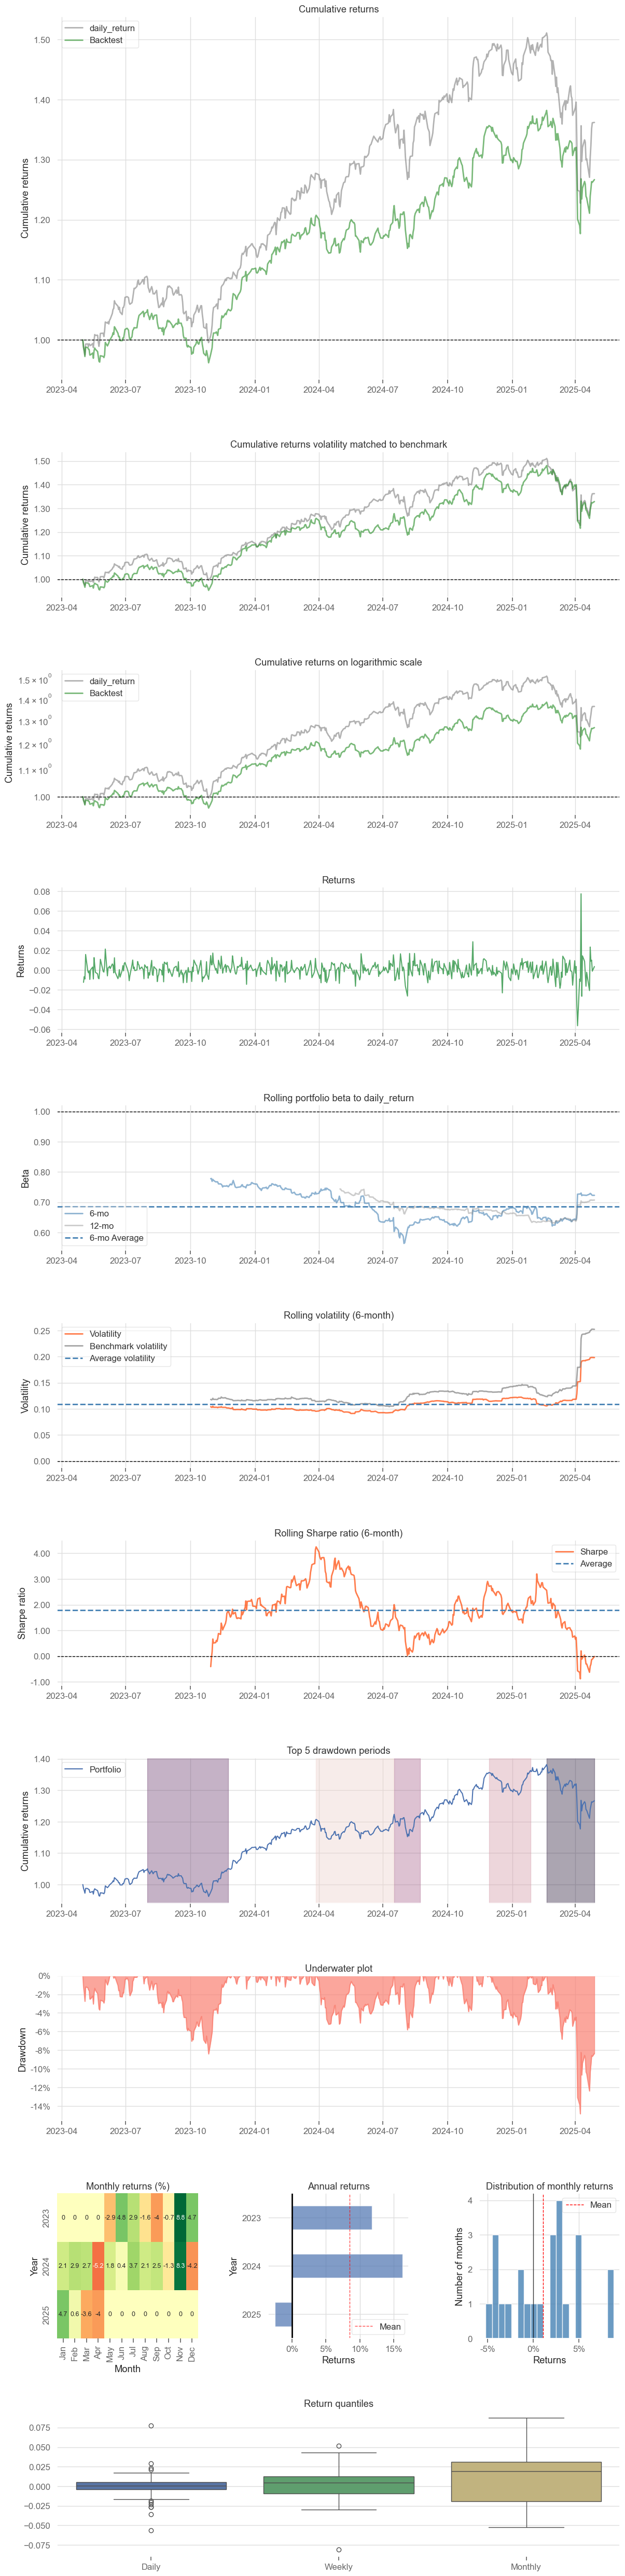

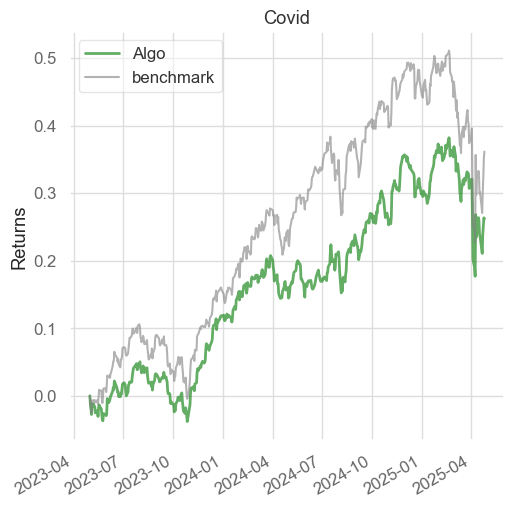

In [58]:
def plot_backtest_results():
    for name, res in results.items():
        print(f"Plotting {name}…")
        backtest_plot(
            account_value=res["df"],
            baseline_start=test_start_date,
            baseline_end=end_date,
            baseline_ticker="SPY",
            value_col_name="account_value",
        )

plot_backtest_results()

## Benchmarks


These benchmarks will provide baseline performance metrics for comparison with the RL strategies.
We evaluate the performance of **Mean-Variance Optimization (MVO)** and simple benchmarks (**Equal-Weighted Portfolio** and **SPY**) in terms of returns, volatility, and cumulative portfolio value.


---

### Mean-Variance Optimization Benchmark

- **Objective**: Calculate the benchmark portfolio using **Mean-Variance Optimization (MVO)**.
- **Purpose**: This function benchmarks the performance of a portfolio optimized for minimum volatility using **Modern Portfolio Theory (MPT)**.
- **Comparison**: It allows us to compare the MPT strategy with other RL strategies by analyzing metrics like returns, volatility, and cumulative performance.

##### Workflow:

1. **Covariance Matrix**:

   - Extract the covariance matrix of asset returns for each trading day in the test period.
   - Use this matrix to model the relationships between asset returns.

2. **Optimization**:

   - Apply **Efficient Frontier** to minimize portfolio volatility.
   - Compute the optimal weights for each asset in the portfolio.

3. **Portfolio Value Calculation**:

   - Calculate the portfolio's account value over time using the optimized weights and asset prices.

4. **Performance Metrics**:
   - Evaluate the portfolio's performance using metrics such as annual return, cumulative return, and volatility.
   - Add the results to the `results` dictionary under the `"MPT"` key.


In [59]:
def compute_mpt_benchmark(test, env_kwargs):
    dates_test = test.date.unique()
    min_vals = [env_kwargs["initial_amount"]]
    for i in range(len(dates_test) - 1):
        curr = test[test.date == dates_test[i]]
        nxt = test[test.date == dates_test[i + 1]]
        covm = np.array(curr.cov_list.values[0])
        ef = EfficientFrontier(None, covm, weight_bounds=(0, 1))
        ef.min_volatility()
        w = ef.clean_weights()
        prices = curr.close.values
        nextp = nxt.close.values
        shares = np.array(list(w.values())) * min_vals[-1] / prices
        min_vals.append(np.dot(shares, nextp))
    min_df = pd.DataFrame({"date": dates_test, "account_value": min_vals})
    stats_mpt = backtest_stats(min_df, value_col_name="account_value")
    return {"df": min_df, "stats": stats_mpt}


mpt_benchmark = compute_mpt_benchmark(test, env_kwargs)

Annual return          0.056834
Cumulative returns     0.115919
Annual volatility      0.110876
Sharpe ratio           0.554931
Calmar ratio           0.542892
Stability              0.848439
Max drawdown          -0.104688
Omega ratio            1.105848
Sortino ratio          0.798648
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.018537
Daily value at risk   -0.013725
dtype: float64


---

### Equal-Weighted Portfolio Benchmark

- Calculate the performance of an **equal-weighted portfolio** benchmark.
- This benchmark assumes that all assets in the portfolio are equally weighted, and their daily returns are averaged to compute the portfolio's overall return.

##### Workflow:

1. **Daily Returns Calculation**:

   - Group the test dataset by `date`.
   - Compute the percentage change (`pct_change`) in the `close` prices for each group.
   - Calculate the mean of the daily percentage changes to represent the portfolio's daily return.

2. **Cumulative Portfolio Value**:

   - Reset the index of the daily returns to create a DataFrame (`ew_df`).
   - Compute the cumulative product of the daily returns (`cumprod`) to calculate the portfolio's cumulative value over time.
   - Multiply the cumulative returns by the initial portfolio value (`initial_amount`) to get the portfolio's account value.

3. **Performance Metrics**:
   - Use the `backtest_stats` function to calculate performance metrics for the equal-weighted portfolio, such as annual return, cumulative return, and volatility.


In [60]:
def compute_equal_weighted_benchmark(df, initial_amount=100_000):
    # Pivot to have one column per ticker
    price_wide = df.pivot_table(
        index="date", columns="tic", values="close"
    ).sort_index()

    # Compute each ticker's daily return, then average equally
    daily_rets = price_wide.pct_change().fillna(0).mean(axis=1)

    # Build the equity curve
    ew_df = pd.DataFrame({"date": daily_rets.index, "daily_return": daily_rets.values})
    ew_df["account_value"] = (ew_df["daily_return"] + 1).cumprod() * initial_amount

    # Compute performance statistics
    stats_ew = backtest_stats(ew_df, value_col_name="account_value")

    return {"df": ew_df.reset_index(drop=True), "stats": stats_ew}


ew_benchmark = compute_equal_weighted_benchmark(test, env_kwargs["initial_amount"])

Annual return          0.103830
Cumulative returns     0.216533
Annual volatility      0.135737
Sharpe ratio           0.796896
Calmar ratio           0.706280
Stability              0.869008
Max drawdown          -0.147010
Omega ratio            1.157670
Sortino ratio          1.173780
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.974921
Daily value at risk   -0.016672
dtype: float64


---

### SPY Benchmark

- **Objective**: Calculate the benchmark performance of the `SPY ETF`, which tracks the **S&P 500** index.
- **Purpose**: This function provides a baseline for comparing the performance of reinforcement learning models and other portfolio strategies.

##### Workflow:

1. **Data Retrieval**:
   - Use the `get_baseline` function to fetch the historical closing prices of the SPY ETF for the test period.
2. **Daily Returns Calculation**:
   - Compute the percentage change (`pct_change`) in the SPY closing prices to calculate daily returns.
3. **Cumulative Portfolio Value**:
   - Create a DataFrame (`spy_df`) with the daily returns and calculate the cumulative product (`cumprod`) of the daily returns to compute the portfolio's cumulative value over time.
   - Multiply the cumulative returns by the initial portfolio value (`initial_amount`) to get the portfolio's account value.
4. **Performance Metrics**:
   - Use the `backtest_stats` function to calculate performance metrics for the SPY benchmark, such as annual return, cumulative return, and volatility.


In [61]:
def compute_spy_benchmark(test, env_kwargs):
    spy_close = get_baseline("SPY", test_start_date, end_date)['close']
    spy_ret = spy_close.pct_change().dropna()
    spy_df = pd.DataFrame({"date": spy_ret.index, "daily_return": spy_ret.values})
    spy_df["account_value"] = (spy_df.daily_return + 1).cumprod() * env_kwargs[
        "initial_amount"
    ]
    stats_spy = backtest_stats(spy_df, value_col_name="account_value")
    return {"df": spy_df, "stats": stats_spy}


spy_benchmark = compute_spy_benchmark(test, env_kwargs)

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (500, 8)
Annual return          0.175562
Cumulative returns     0.377518
Annual volatility      0.163888
Sharpe ratio           1.070416
Calmar ratio           0.936068
Stability              0.874014
Max drawdown          -0.187552
Omega ratio            1.228944
Sortino ratio          1.592022
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.914132
Daily value at risk   -0.019952
dtype: float64


In [62]:
benchmarks = {
    "MPT": mpt_benchmark,
    "EW": ew_benchmark,
    "SPY": spy_benchmark,
}

results.update(benchmarks)

## Performance Summary


In [63]:
perf_stats = pd.DataFrame({key.upper(): res["stats"] for key, res in results.items()})
display(perf_stats)

,A2C,PPO,SAC,DDPG,MPT,EW,SPY
Annual return,0.110256,0.104025,0.127527,0.126599,0.056834,0.103830,0.175562
Cumulative returns,0.230624,0.216958,0.268898,0.266826,0.115919,0.216533,0.377518
Annual volatility,0.131050,0.135741,0.133352,0.134208,0.110876,0.135737,0.163888
Sharpe ratio,0.865088,0.798180,0.968505,0.956921,0.554931,0.796896,1.070416
Calmar ratio,0.854477,0.708035,0.948349,0.852798,0.542892,0.706280,0.936068
Stability,0.888910,0.869242,0.905302,0.895393,0.848439,0.869008,0.874014
Max drawdown,-0.129034,-0.146921,-0.134473,-0.148451,-0.104688,-0.147010,-0.187552
Omega ratio,1.169014,1.157937,1.191165,1.193771,1.105848,1.157670,1.228944
Sortino ratio,1.288912,1.175795,1.436089,1.422052,0.798648,1.173780,1.592022
Skew,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Visualize the cumulative returns of various strategies over time


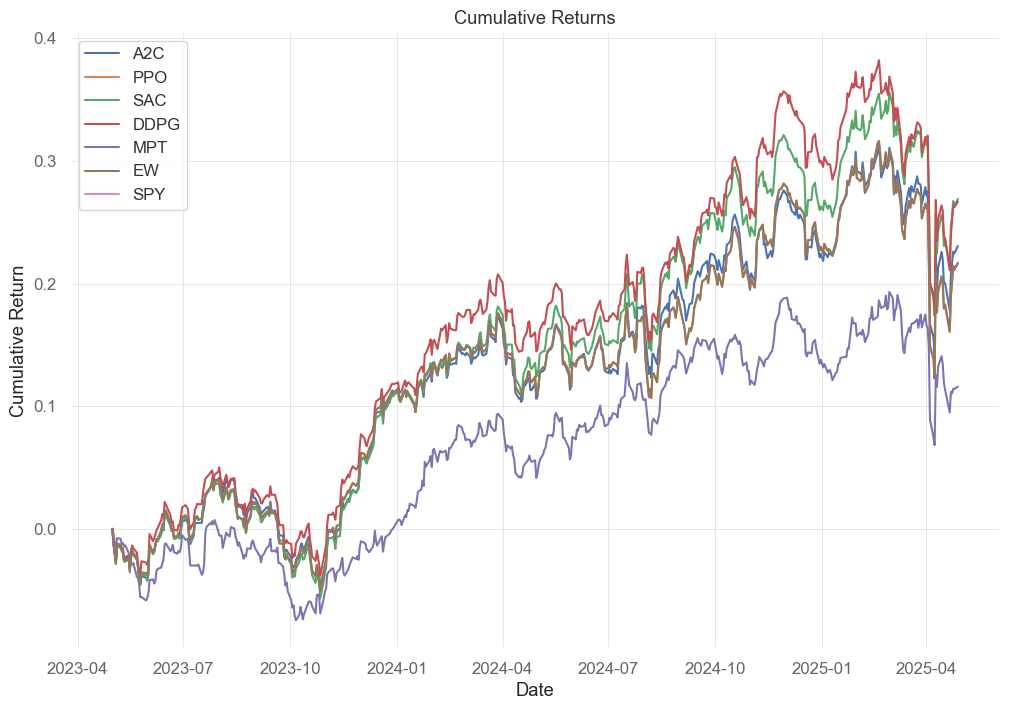

In [ ]:
def plot_cumulative_returns(results):
    plt.figure(figsize=(12, 8))
    for name, res in results.items():
        # Ensure the date column is converted to datetime
        res["df"]["date"] = pd.to_datetime(res["df"]["date"])
        # Filter data to start from the trade start date
        filtered_df = res["df"][res["df"]["date"] >= test_start_date]
        cum = (
            (filtered_df["daily_return"] + 1).cumprod() - 1
            if "daily_return" in filtered_df
            else filtered_df["account_value"] / filtered_df["account_value"].iloc[0] - 1
        )
        plt.plot(filtered_df["date"], cum, label=name)
    plt.title("Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()

plot_cumulative_returns(results)